# **Research Notebook 04: DistilBERT Fine-Tuning**

**Objective:** Fine-tune a pre-trained DistilBERT transformer on the *'preprocessed_text_bert'* column to capture deep semantic context.

In [1]:
# Install Dependencies

# We need to install the Hugging Face libraries.
!pip install -q transformers datasets accelerate

In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed
)

from datasets import Dataset
import os

In [3]:
# Reproducibility

# Ensures that our results are the same every time we run this.
set_seed(101)

In [4]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define File Paths

base_path = '/content/drive/MyDrive/Research/'

# Load the Clean dataset
train_path = f'{base_path}datasets/train_dataset_clean.csv'
test_path  = f'{base_path}datasets/test_dataset_clean.csv'
model_save_path = f'{base_path}models/distilbert_finetuned_cased'
evaluation_path = f'{base_path}evaluation/'

In [6]:
# Load Training Data

print("Loading and preparing training data...")
df = pd.read_csv(train_path)
df = df.dropna(subset=['preprocessed_text_bert'])

# Map labels to numbers
label_map = {'fake': 0, 'real': 1}
df['label'] = df['label'].map(label_map)

# Select columns
df = df[['preprocessed_text_bert', 'label']]
df.columns = ['text', 'label']

# Create internal validation set (stratified)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=101
)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset   = Dataset.from_pandas(val_df.reset_index(drop=True))

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")

Loading and preparing training data...
Train samples: 7219
Val samples:   1805


In [7]:
# Tokenization

print("Loading Tokenizer (distilbert-base-cased)...")
tokenizer = DistilBertTokenizerFast.from_pretrained(
    'distilbert-base-cased'
)

def tokenize_function(batch):
    return tokenizer(
        batch['text'],
        truncation=True,
        max_length=512
    )

print("Tokenizing datasets...")
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized   = val_dataset.map(tokenize_function, batched=True)

# Data Collator handles the dynamic padding during training
data_collator = DataCollatorWithPadding(tokenizer)
print("\nTokenization complete.")

Loading Tokenizer (distilbert-base-cased)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Tokenizing datasets...


Map:   0%|          | 0/7219 [00:00<?, ? examples/s]

Map:   0%|          | 0/1805 [00:00<?, ? examples/s]


Tokenization complete.


In [8]:
# Metrics

print("Defining evaluation metrics function...")
def compute_metrics(pred):
    labels = pred.label_ids
    logits = pred.predictions

    # Calculate probabilities for ROC AUC
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = logits.argmax(axis=-1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='macro'
    )
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs[:, 1])

    return {
        'accuracy': acc,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1,
        'auc': auc
    }

Defining evaluation metrics function...


In [9]:
# Model Initialization (FULL FINE-TUNING)

print("Initializing Model (distilbert-base-cased)...")
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased',
    num_labels=2
)

Initializing Model (distilbert-base-cased)...


model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Training Arguments

print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,                 # 3 Epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    # Evaluation Strategy
    eval_strategy='epoch',        # Evaluate every epoch
    save_strategy='epoch',              # Save checkpoint every epoch
    load_best_model_at_end=True,        # Always load the best checkpoint
    metric_for_best_model='f1_macro',         # Optimize for F1 Score
    greater_is_better=True,

    # Hyperparameters
    learning_rate=3e-5,                 # Explicit Learning Rate
    warmup_steps=500,
    weight_decay=0.01,

    # Logging
    logging_strategy='epoch',           # Log per epoch
    report_to='none'
)

Setting up training arguments...


In [15]:
# Trainer

print("Initializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    processing_class=tokenizer,
    data_collator=data_collator,        # Enables dynamic padding
    compute_metrics=compute_metrics
)

Initializing Trainer...


In [16]:
# Confirm device usage

print(f"Trainer will use device: {trainer.args.device}")

Trainer will use device: cuda:0


In [17]:
# Fine-Tuning

print("Starting Fine-Tuning (Training)...")
trainer.train()
print("\nTraining complete.")

Starting Fine-Tuning (Training)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,Auc
1,0.014000,0.013882,0.997784,0.997787,0.997783,0.997784,0.999974
2,0.013300,0.008278,0.997784,0.997787,0.997783,0.997784,0.999964
3,0.000300,0.005741,0.999446,0.999446,0.999446,0.999446,0.999982



Training complete.


In [18]:
# Save Model

print(f"Saving final model to: {model_save_path}")
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print("\nModel and tokenizer saved.")

Saving final model to: /content/drive/MyDrive/Research/models/distilbert_finetuned_cased

Model and tokenizer saved.


In [20]:
# Final Evaluation on TEST Set

print("Running Final Evaluation on Held-Out Test Set...")

# Load Test Data
test_df = pd.read_csv(test_path)
test_df = test_df.dropna(subset=['preprocessed_text_bert'])
test_df['label'] = test_df['label'].map(label_map)

test_df = test_df[['preprocessed_text_bert', 'label']]
test_df.columns = ['text', 'label']

# Prepare Test Dataset
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Predict
test_results = trainer.evaluate(test_tokenized)

print("\n--- TEST SET RESULTS ---")
for k, v in test_results.items():
    if k.startswith("eval_"):
        print(f"{k.replace('eval_', '').upper()}: {v:.4f}")

Running Final Evaluation on Held-Out Test Set...


Map:   0%|          | 0/2256 [00:00<?, ? examples/s]


--- TEST SET RESULTS ---
LOSS: 0.0028
ACCURACY: 0.9996
PRECISION_MACRO: 0.9996
RECALL_MACRO: 0.9996
F1_MACRO: 0.9996
AUC: 1.0000
RUNTIME: 36.7746
SAMPLES_PER_SECOND: 61.3470
STEPS_PER_SECOND: 1.9310


In [22]:
# Extract metrics from trainer evaluation

distilbert_metrics = {
    "model": "distilbert_model",
    "accuracy": test_results["eval_accuracy"],
    "precision_macro": test_results["eval_precision_macro"],
    "recall_macro": test_results["eval_recall_macro"],
    "f1_macro": test_results["eval_f1_macro"],
    "roc_auc": test_results["eval_auc"]
}

distilbert_metrics_df = pd.DataFrame([distilbert_metrics])

metrics_save_path = f'{evaluation_path}distilbert_model_metrics.csv'
distilbert_metrics_df.to_csv(metrics_save_path, index=False)

print(f"DistilBERT metrics saved to: {metrics_save_path}")

DistilBERT metrics saved to: /content/drive/MyDrive/Research/evaluation/distilbert_model_metrics.csv


Generating Confusion Matrix...



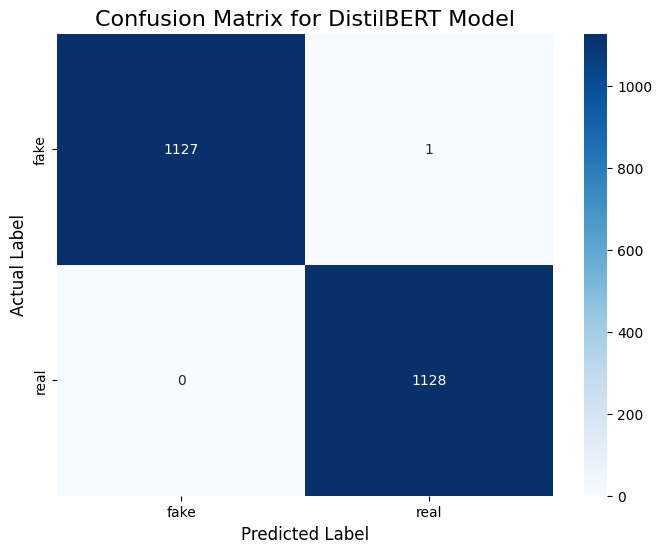


DistilBERT confusion matrix saved to: /content/drive/MyDrive/Research/evaluation/distilbert_model_confusion_matrix.png


In [23]:
# Visualize the Confusion Matrix

print("Generating Confusion Matrix...\n")

# Get predictions and probabilities
predictions = trainer.predict(test_tokenized)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['fake', 'real']

cm_save_path = f'{evaluation_path}distilbert_model_confusion_matrix.png'

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for DistilBERT Model', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('Actual Label', fontsize=12)
plt.savefig(cm_save_path, dpi=300)
plt.show()

print(f"\nDistilBERT confusion matrix saved to: {cm_save_path}")

Generating ROC Curve...



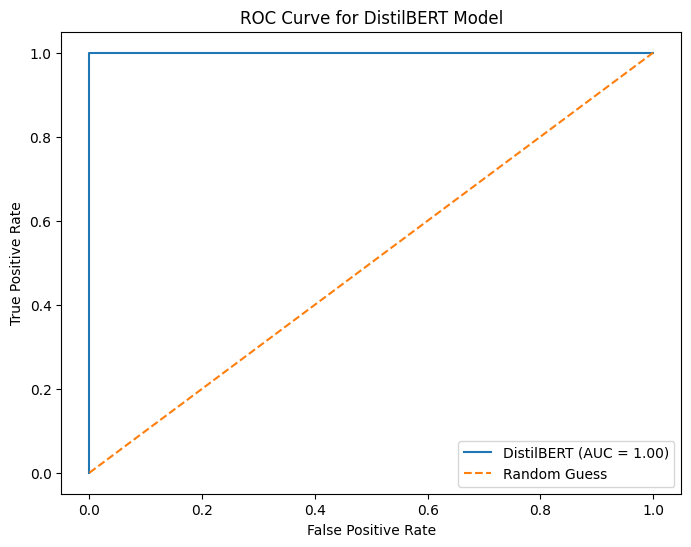


DistilBERT ROC curve saved to: /content/drive/MyDrive/Research/evaluation/distilbert_model_roc_curve.png

--- DistilBERT Fine-Tuning Complete ---


In [24]:
# Visualize the ROC AUC Curve

print("Generating ROC Curve...\n")

# Compute probabilities
probs = F.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
y_probs = probs[:, 1]  # Probability of 'real'

fpr, tpr, _ = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

roc_save_path = f'{evaluation_path}distilbert_model_roc_curve.png'

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'DistilBERT (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DistilBERT Model')
plt.legend()
plt.savefig(roc_save_path, dpi=300)
plt.show()

print(f"\nDistilBERT ROC curve saved to: {roc_save_path}")

print("\n--- DistilBERT Fine-Tuning Complete ---")